In [1]:
import uproot
import numpy as np
import awkward as ak

import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep

from scipy.optimize import curve_fit
from scipy.stats import binned_statistic

mpl.rc('image', cmap='Purples')
plt.style.use(hep.style.CMS)

In [2]:
from scipy.stats import norm

gauss_pdf = lambda x, mu, k, s: k * norm.pdf(x, mu, s)
gauss2_pdf = lambda x, m1, k1, s1, m2, k2, s2: gauss_pdf(x, m1, k1, s1) + gauss_pdf(x, m2, k2, s2)

In [3]:
f = uproot.open("/home/work/gem/testbeam/may2022/tracks/00000135_full.root")
f.keys()

['trackTree;1244', 'trackTree;1243']

In [4]:
t = f["trackTree"]
t.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
orbitNumber          | int32_t                  | AsDtype('>i4')
bunchCounter         | int32_t                  | AsDtype('>i4')
eventCounter         | int32_t                  | AsDtype('>i4')
rechitDigiStrip      | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
rechitRawChannel     | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
rechitChamber        | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
rechitEta            | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
rechitLocalX         | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
rechitLocalY         | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
rechitR              | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
rechitPhi            | std::vector<double>      | AsJagged(AsDtype('>f8'), h

In [158]:
events = t.arrays(
    [
        "rechitChamber", "rechitEta",
        "rechitLocalX", "rechitLocalY", "rechitClusterSize",
        "rechitR", "rechitPhi",
        "prophitChamber", "trackChi2",
        "prophitLocalX", "prophitLocalY",
        "prophitGlobalX", "prophitGlobalY",
        "prophitR", "prophitPhi"
    ], entry_stop=2000000
)

In [159]:
rechits_chamber = events["rechitChamber"]
rechits_eta = events["rechitEta"]
rechits_cluster_size = events["rechitClusterSize"]
rechits_x = events["rechitLocalX"]
rechits_y = events["rechitLocalY"]
rechits_r = events["rechitR"]
rechits_phi = events["rechitPhi"]

print(rechits_chamber, ak.count(rechits_chamber, axis=1))
print(rechits_x, ak.count(rechits_x, axis=1))
print(rechits_y, ak.count(rechits_y, axis=1))

[[0, 1, 2, 3, 4, 5, 8, 9, 10], [0, 1, 2, ... 9, 10], [0, 1, 2, 3, 4, 5, 8, 8, 9, 10]] [9, 8, 9, 10, 7, 9, 4, 7, 8, 9, 2, 8, 9, ... 8, 3, 7, 8, 8, 12, 10, 7, 7, 10, 7, 10]
[[41.6, -19.1, 42.4, -23.8, 42.1, -27.8, ... 12.1, 4.12, 120, 112, -31.6, -38.2]] [9, 8, 9, 10, 7, 9, 4, 7, 8, 9, 2, 8, 9, ... 8, 3, 7, 8, 8, 12, 10, 7, 7, 10, 7, 10]
[[0, 0, 0, 0, 0, 0, 48.9, 246, 246], ... 0, 0, 0, 0, 0, 0, -48.9, -48.9, 246, 246]] [9, 8, 9, 10, 7, 9, 4, 7, 8, 9, 2, 8, 9, ... 8, 3, 7, 8, 8, 12, 10, 7, 7, 10, 7, 10]


In [160]:
prophits_chamber = events["prophitChamber"]
prophits_x = events["prophitLocalX"]
prophits_y = events["prophitLocalY"]
prophits_r = events["prophitR"]
prophits_phi = events["prophitPhi"]
track_chi2 = events["trackChi2"]

print(prophits_chamber, ak.count(prophits_chamber, axis=1))
print(prophits_x, ak.count(prophits_x, axis=1))
print(prophits_y, ak.count(prophits_y, axis=1))
print(track_chi2)

[[8, 9, 10], [8, 9, 10], [8, 9, 10], [8, ... 10], [8, 9, 10], [8, 9, 10], [8, 9, 10]] [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ... 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[[42.9, -9.06, -17.9], [-13, 9.69, 0.997, ... 1.79, -6.9], [12.9, -40.7, -49.4]] [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ... 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[[27.6, 556, 560], [46.4, 612, 616], [29, ... [38.4, 614, 619], [-4.01, 586, 591]] [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ... 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[1.75e+03, 1.89e+03, 544, 1.19e+03, 1.98e+03, ... 834, 1.22e+03, 752, 1.29e+03, 154]


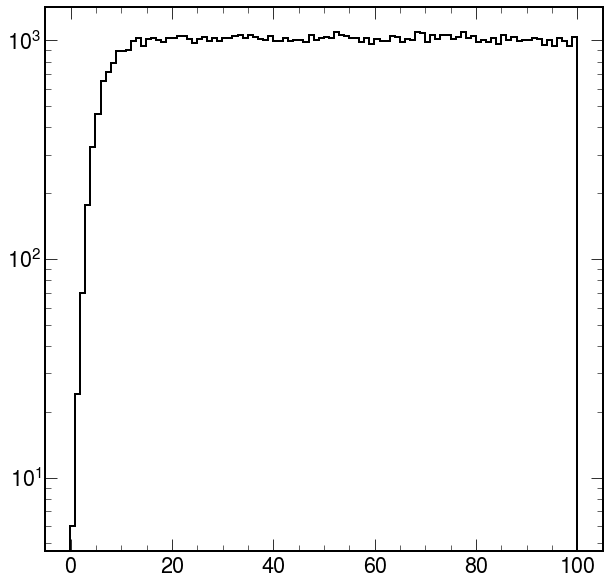

In [161]:
_ = plt.hist(
    track_chi2,
    bins=100, range=(-0.1,100),
    histtype="step", color="k", linewidth=2
)
plt.yscale("log")

In [162]:
tested_chamber = 9

rechits_eta_chamber = rechits_eta[rechits_chamber==tested_chamber]
rechits_cluster_size_chamber = rechits_cluster_size[rechits_chamber==tested_chamber]
rechits_x_chamber = rechits_x[rechits_chamber==tested_chamber]
rechits_y_chamber = rechits_y[rechits_chamber==tested_chamber]
rechits_r_chamber = rechits_r[rechits_chamber==tested_chamber]
rechits_phi_chamber = rechits_phi[rechits_chamber==tested_chamber]
prophits_x_chamber = prophits_x[prophits_chamber==tested_chamber]
prophits_y_chamber = prophits_y[prophits_chamber==tested_chamber]
prophits_r_chamber = prophits_r[prophits_chamber==tested_chamber]
prophits_phi_chamber = prophits_phi[prophits_chamber==tested_chamber]

print("Eta", rechits_eta_chamber)
print("Rechit x", rechits_x_chamber)
print("Rechit cluster size", rechits_cluster_size_chamber)
print("Rechit y", rechits_y_chamber)
print("Rechit r", rechits_r_chamber)
print(rechits_r_chamber - rechits_y_chamber)
print("Prophit x", prophits_x_chamber)
print("Prophit y", prophits_y_chamber)
print("Prophit r", prophits_r_chamber)
print(prophits_r_chamber - prophits_y_chamber)

coarse_efficiency = ak.count_nonzero(ak.num(rechits_x_chamber, axis=1)>0) / ak.num(prophits_x_chamber, axis=0)
print(ak.num(rechits_x_chamber, axis=1)>0)
print("Matching", ak.count_nonzero(ak.num(rechits_x_chamber, axis=1)>0))
print("Triggers", ak.num(prophits_x_chamber, axis=0))
print(coarse_efficiency)

Eta [[2], [2], [2], [2], [2], [2], [2], [2, ... 2], [2, 2], [2], [2], [2, 2], [2], [2]]
Rechit x [[-6.22], [7.56], [-5.78], [-52.9], ... [2.67], [-30.2, -28.4], [1.33], [-31.6]]
Rechit cluster size [[1], [2], [2], [2], [3], [2], [2], [1, ... 2], [4, 1], [1], [3], [1, 1], [2], [2]]
Rechit y [[246], [246], [246], [246], [246], [246, ... [246], [246], [246, 246], [246], [246]]
Rechit r [[1.19e+03], [1.19e+03], [1.19e+03], ... 1.19e+03, 1.19e+03], [1.19e+03], [1.19e+03]]
[[940], [940], [940], [941], [940], [940, ... [940], [940], [940, 940], [940], [940]]
Prophit x [[-9.06], [9.69], [-7.63], [-67.2], [5.96, ... [2.85], [-38.3], [1.79], [-40.7]]
Prophit y [[556], [612], [592], [577], [626], [581, ... [628], [605], [630], [614], [586]]
Prophit r [[1.5e+03], [1.55e+03], [1.53e+03], ... [1.57e+03], [1.55e+03], [1.53e+03]]
[[940], [940], [940], [941], [940], [940, ... [940], [940], [940], [940], [940]]
[True, True, True, True, True, True, True, ... True, True, True, True, True, True]
Matching 1

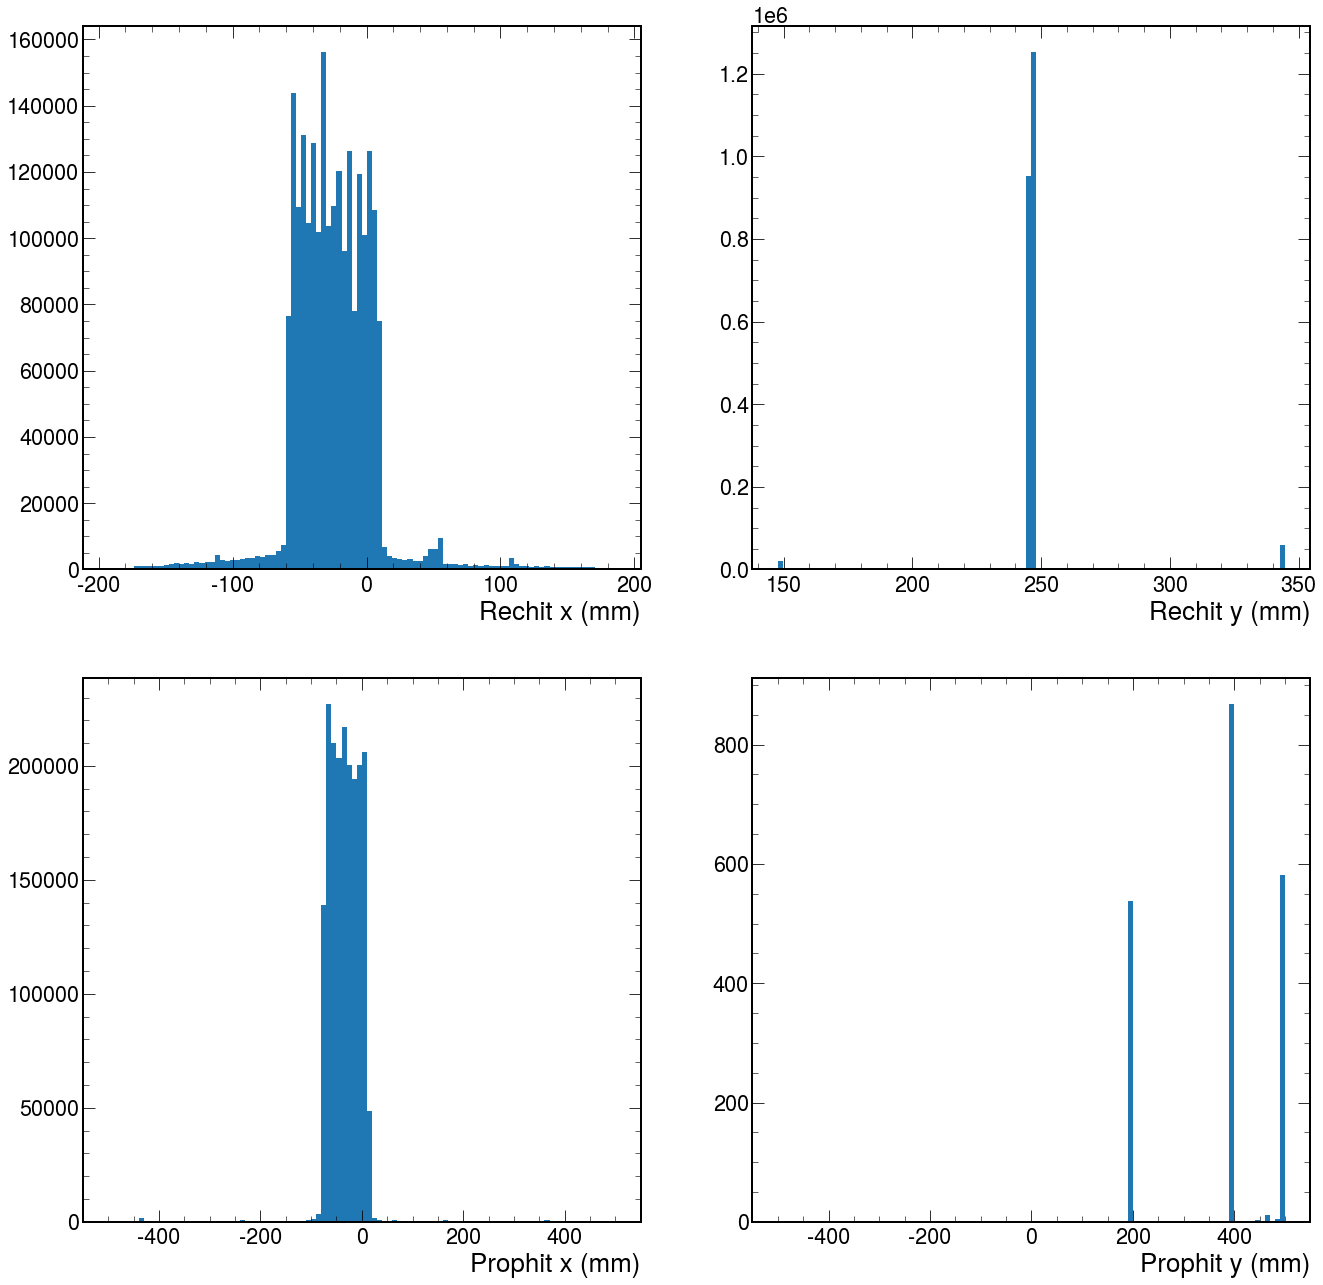

In [163]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(22,22))
_ = ax[0][0].hist(ak.flatten(rechits_x_chamber), bins=100)#, range=(-50,50))
_ = ax[0][1].hist(ak.flatten(rechits_y_chamber), bins=100)#, range=(-50,50))
_ = ax[1][0].hist(ak.flatten(prophits_x_chamber), bins=100, range=(-500,500))
_ = ax[1][1].hist(ak.flatten(prophits_y_chamber), bins=100, range=(-500,500))

_ = ax[0][0].set_xlabel("Rechit x (mm)")
_ = ax[0][1].set_xlabel("Rechit y (mm)")
_ = ax[1][0].set_xlabel("Prophit x (mm)")
_ = ax[1][1].set_xlabel("Prophit y (mm)")

Text(0, 1, 'Prophits y (mm)')

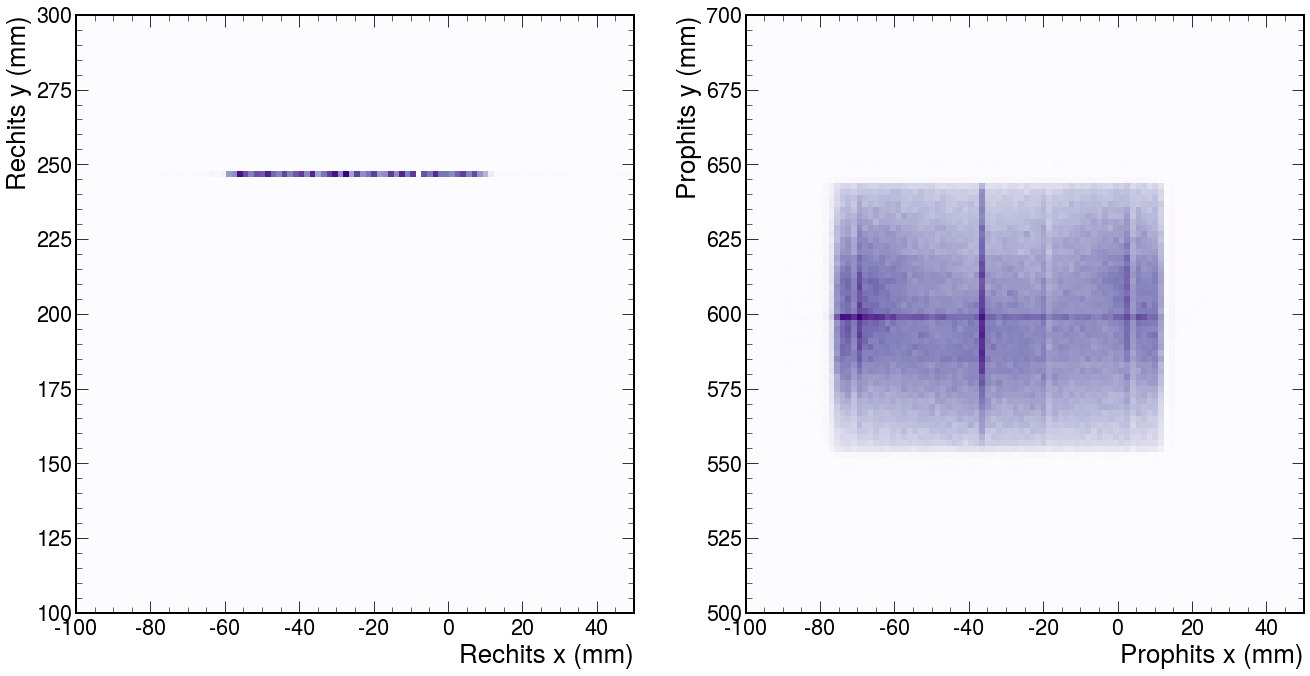

In [164]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22,11))
_ = ax[0].hist2d(
    ak.flatten(rechits_x_chamber), ak.flatten(rechits_y_chamber),
    bins=(100,100), range=((-100,50),(100,300))
)
_ = ax[1].hist2d(
    ak.flatten(prophits_x_chamber), ak.flatten(prophits_y_chamber),
    bins=(100,100), range=((-100,50),(500,700))
)
ax[0].set_xlabel("Rechits x (mm)")
ax[0].set_ylabel("Rechits y (mm)")
ax[1].set_xlabel("Prophits x (mm)")
ax[1].set_ylabel("Prophits y (mm)")

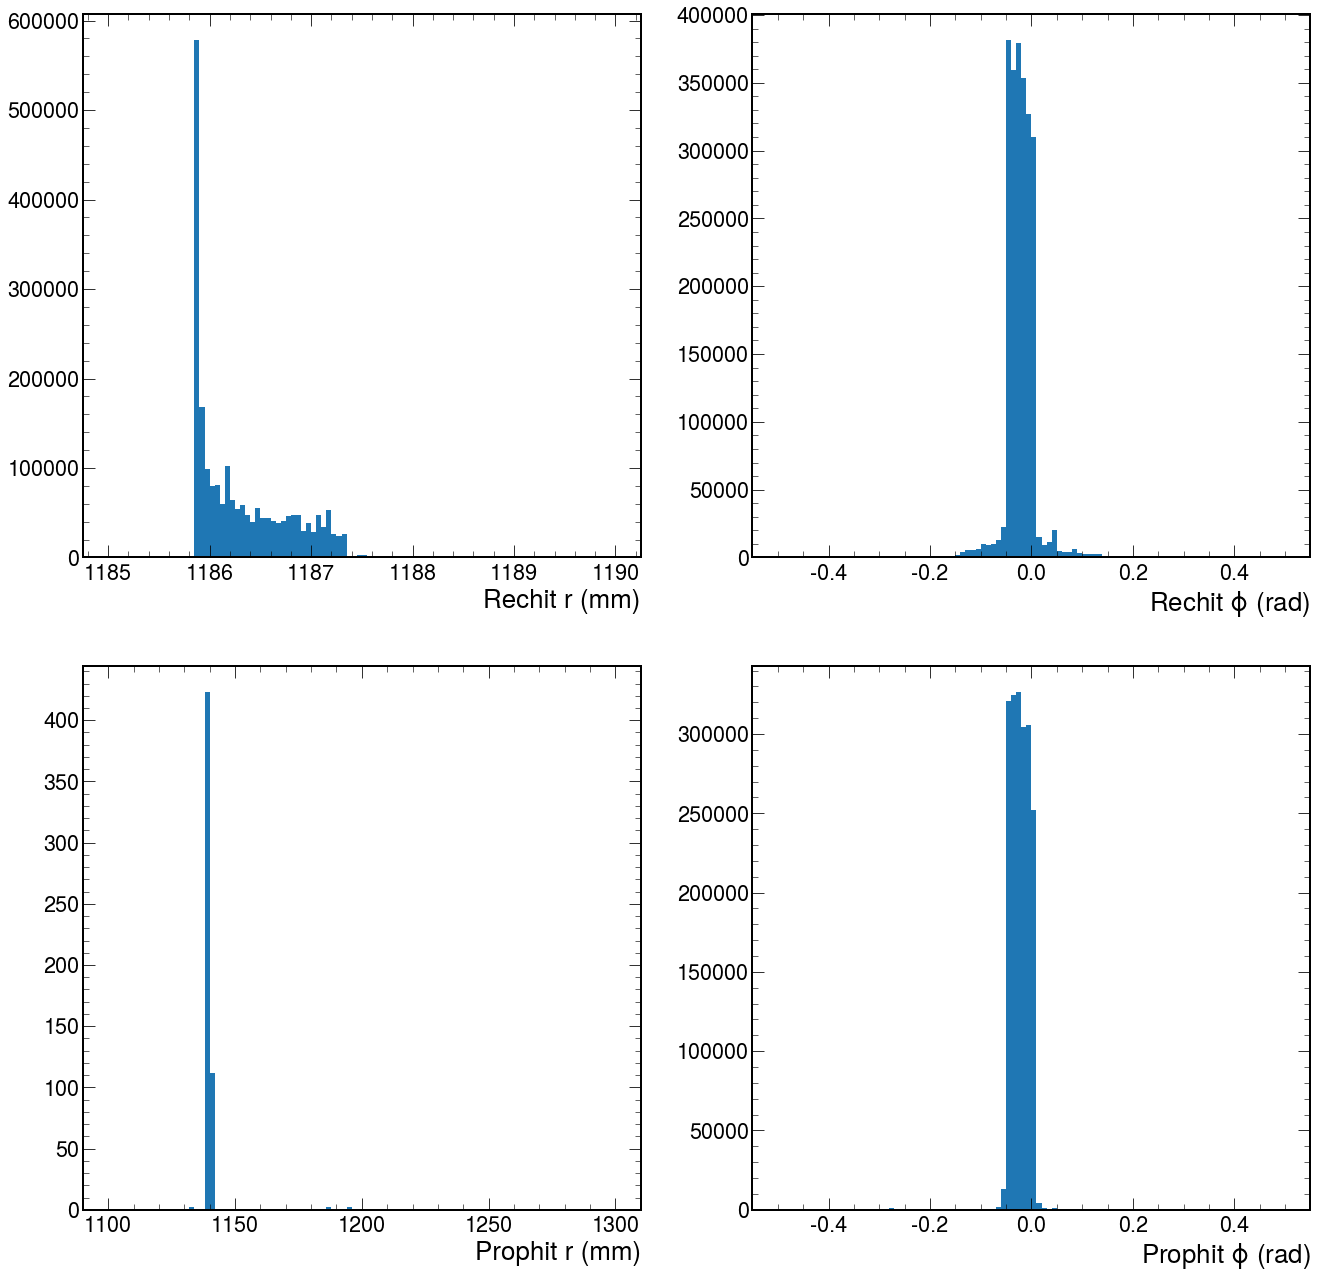

In [165]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(22,22))
_ = ax[0][0].hist(ak.flatten(rechits_r_chamber), bins=100, range=(1185,1190))
_ = ax[0][1].hist(ak.flatten(rechits_phi_chamber), bins=100, range=(-0.5,0.5))
_ = ax[1][0].hist(ak.flatten(prophits_r_chamber), bins=100, range=(1100,1300))
_ = ax[1][1].hist(ak.flatten(prophits_phi_chamber), bins=100, range=(-0.5,0.5))

_ = ax[0][0].set_xlabel("Rechit r (mm)")
_ = ax[0][1].set_xlabel("Rechit $\phi$ (rad)")
_ = ax[1][0].set_xlabel("Prophit r (mm)")
_ = ax[1][1].set_xlabel("Prophit $\phi$ (rad)")

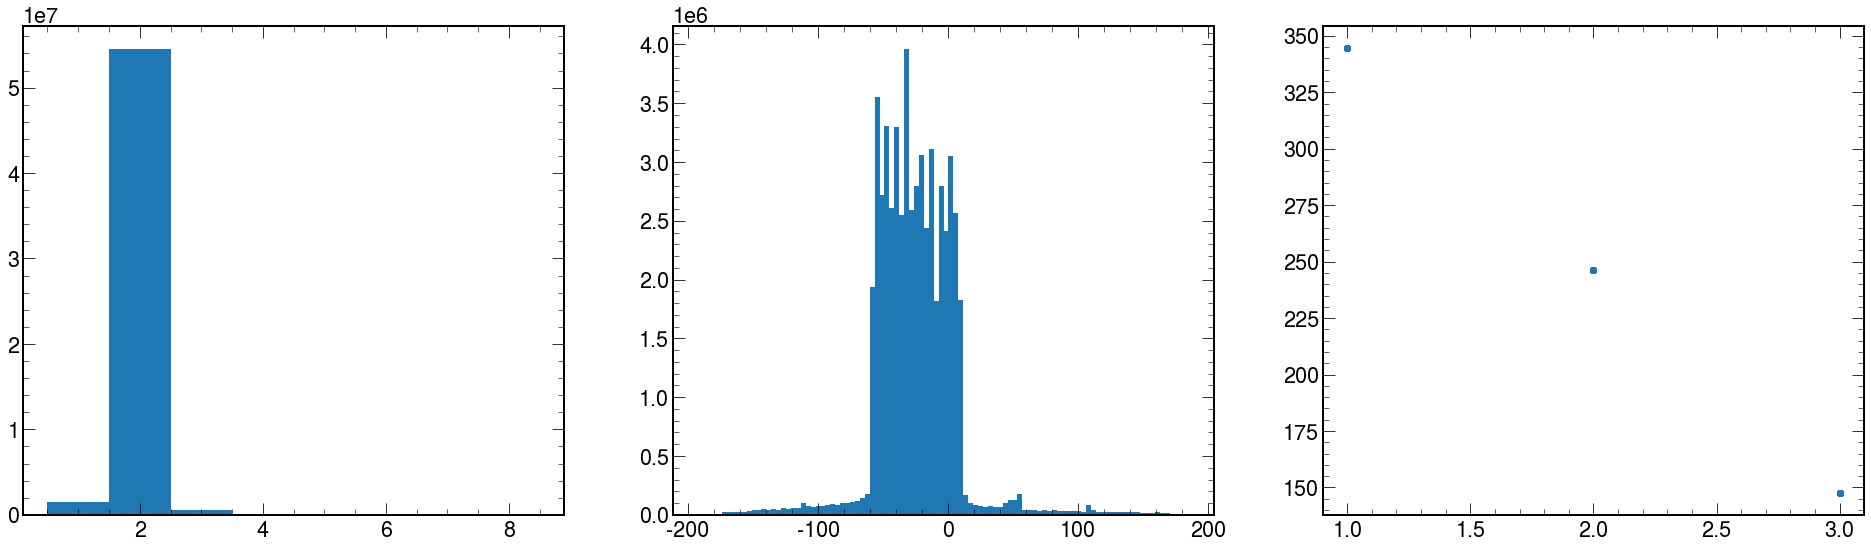

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(33,9))
_ = ax[0].hist(ak.flatten(rechits_eta_chamber), bins=8, range=(0.5, 8.5))
_ = ax[1].hist(ak.flatten(rechits_x_chamber), bins=100)#, range=(-50,50))
_ = ax[2].scatter(
    ak.flatten(rechits_eta_chamber), ak.flatten(rechits_y_chamber),
    #bins=(8,8), range=((0.5,8.5),(-400,400))
)

Text(0, 1, 'Prophits y (mm)')

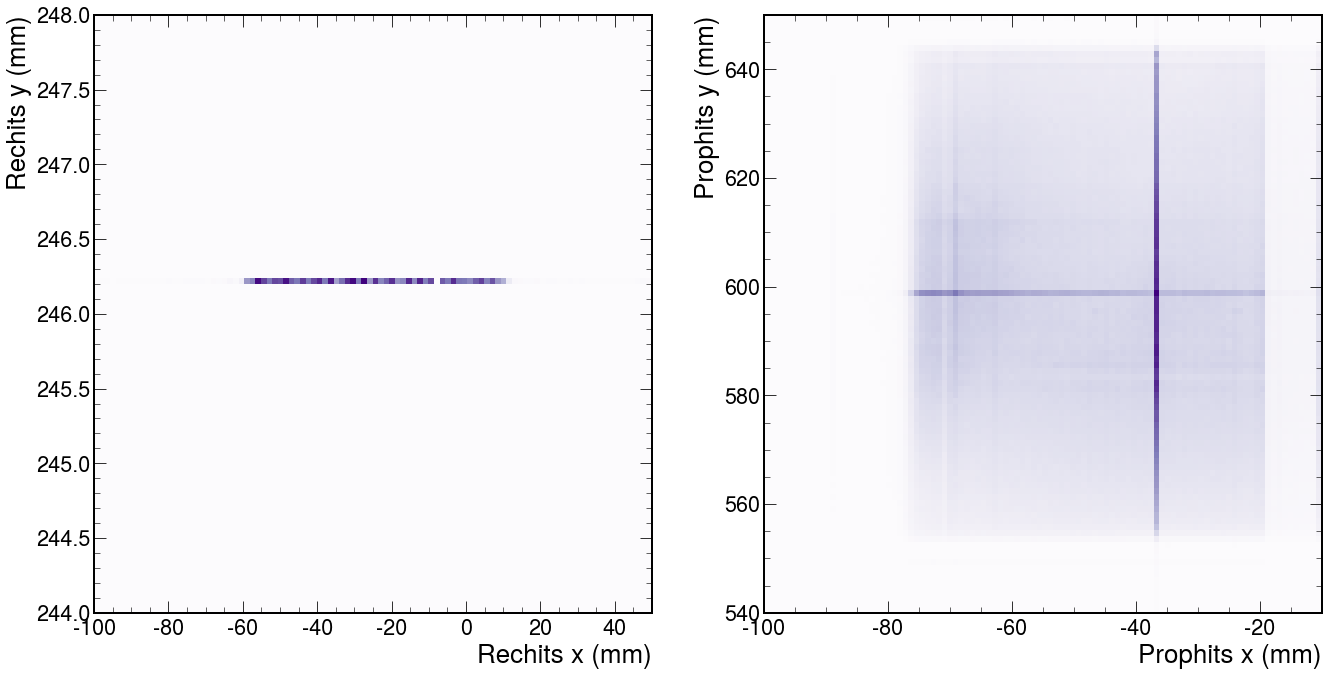

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22,11))
_ = ax[0].hist2d(
    ak.flatten(rechits_x_chamber), ak.flatten(rechits_y_chamber),
    bins=(100,100), range=((-100,50),(244,248))
)
_ = ax[1].hist2d(
    ak.flatten(prophits_x_chamber), ak.flatten(prophits_y_chamber),
    bins=(100,100), range=((-100,-10),(540,650))
)
ax[0].set_xlabel("Rechits x (mm)")
ax[0].set_ylabel("Rechits y (mm)")
ax[1].set_xlabel("Prophits x (mm)")
ax[1].set_ylabel("Prophits y (mm)")

In [67]:
# choose only events with a prophit and broadcast the prophits
residual_filter = ak.count(prophits_x_chamber, axis=1)==1
#residual_filter = residual_filter&(track_chi2>1)

rechits_x_broadcast, prophits_x_broadcast = ak.broadcast_arrays(
    rechits_x_chamber[residual_filter],
    ak.flatten(prophits_x_chamber[residual_filter])
)
print("Rechits x:", rechits_x_broadcast)
print("Prophits x:", prophits_x_broadcast)

rechits_y_broadcast, prophits_y_broadcast = ak.broadcast_arrays(
    rechits_y_chamber[residual_filter],
    ak.flatten(prophits_y_chamber[residual_filter])
)
print("Rechits y:", rechits_y_broadcast)
print("Prophits y:", prophits_y_broadcast)

residuals_y = rechits_y_broadcast-prophits_y_broadcast
residuals_x = rechits_x_broadcast-prophits_x_broadcast

rechits_r_broadcast, prophits_r_broadcast = ak.broadcast_arrays(
    rechits_r_chamber[residual_filter],
    ak.flatten(prophits_r_chamber[residual_filter])
)
rechits_phi_broadcast, prophits_phi_broadcast = ak.broadcast_arrays(
    rechits_phi_chamber[residual_filter],
    ak.flatten(prophits_phi_chamber[residual_filter])
)
rechits_cluster_size_broadcast, prophits_phi_broadcast = ak.broadcast_arrays(
    rechits_phi_chamber[residual_filter],
    ak.flatten(prophits_phi_chamber[residual_filter])
)
residuals_polar = prophits_r_broadcast * (rechits_phi_broadcast - prophits_phi_broadcast)
residuals_phi = rechits_phi_broadcast - prophits_phi_broadcast

Rechits x: [[-6.22], [7.56], [-5.78], [-52.9], ... [-63.6, -58.2], [-8.89], [-21.8], [1.78]]
Prophits x: [[-9.06], [9.69], [-7.63], [-67.2], [5.96, ... [-74.6, -74.6], [nan], [-29.2], [nan]]
Rechits y: [[246], [246], [246], [246], [246], [246, ... [246], [246, 246], [246], [246], [246]]
Prophits y: [[556], [612], [592], [577], [626], [581, ... [622], [586, 586], [nan], [617], [nan]]


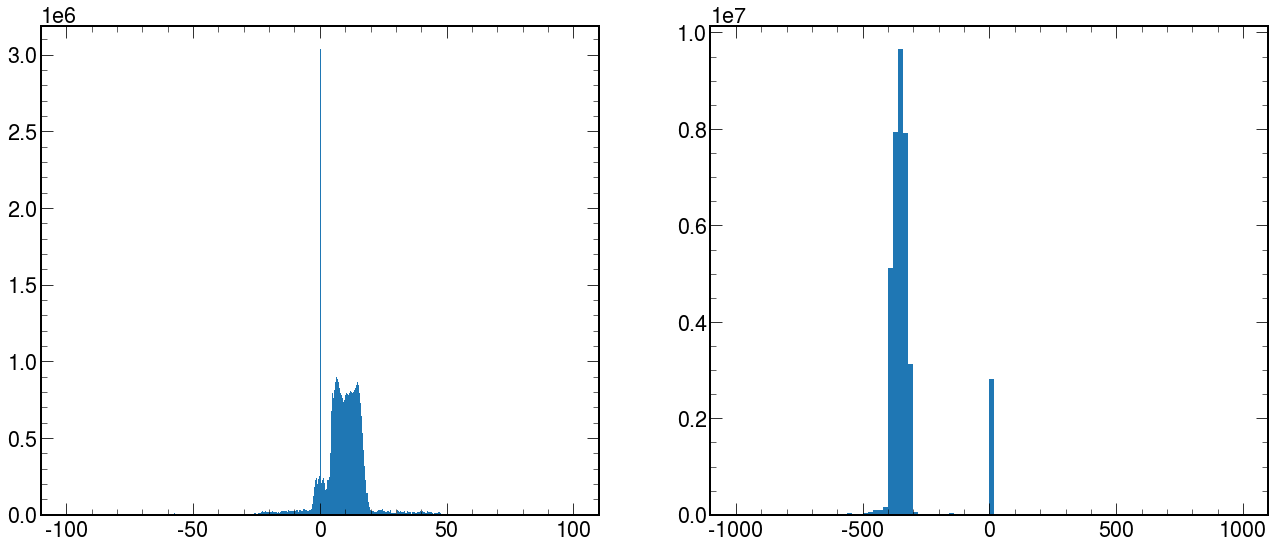

In [68]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22,9))
_ = ax[0].hist(ak.min(residuals_x, axis=1), bins=500, range=(-100,100))
_ = ax[1].hist(ak.min(residuals_y, axis=1), bins=100, range=(-1000,1000))

Correction phi -0.01703232408083554 ± 0.0012454991396465358 mrad
Resolution phi 0.22735253715474446 ± 0.0012454992985005857 mrad


Text(0.05, 0.9, 'Mean -0.02 $\\pm$ 0.00 mrad\nSigma 227.35 $\\pm$ 1.25 µrad\n')

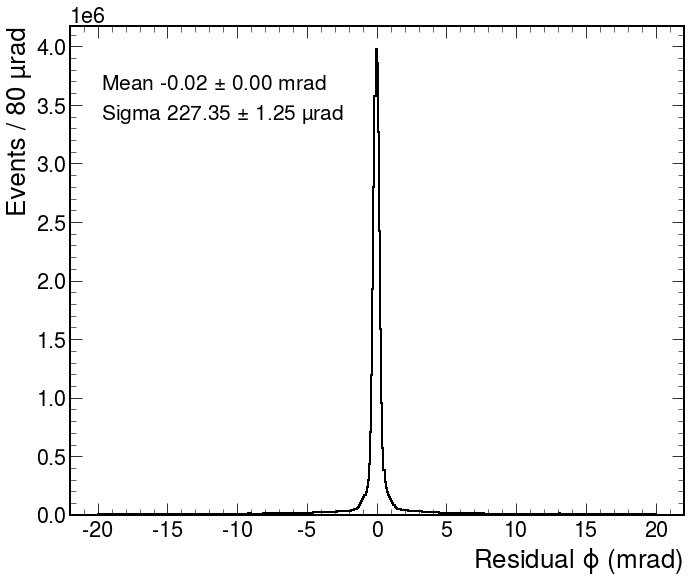

In [69]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11,9))
residuals_phi_flat = ak.flatten(residuals_phi).to_numpy()*1e3
polar_values, polar_edges, _ = ax.hist(
    residuals_phi_flat,
    bins=500, range=(-20,20),
    histtype="step", linewidth=2, color="k"
)
polar_centers = 0.5*(polar_edges[1:]+polar_edges[:-1])

popt = [ 0, 1000, 0.2 ]
#popt += [ delta_t.mean(), delta_t.max(), delta_t.std() ]
popt, pcov = curve_fit(gauss_pdf, polar_centers, polar_values)
perr = np.sqrt(np.diag(pcov))
phi_correction, phi_resolution = popt[0], popt[2]
err_phi_correction, err_phi_resolution = perr[0], perr[2]
print("Correction phi", phi_correction, "±", err_phi_correction, "mrad")
print("Resolution phi", phi_resolution, "±", err_phi_resolution, "mrad")
perr = np.sqrt(np.diag(pcov))

phi = np.linspace(polar_edges[0], polar_edges[:-1], 500)
#_ = ax.plot(phi, gauss_pdf(phi, *popt), linewidth=2, color="red")

binning = np.diff(polar_edges).mean()
ax.set_xlabel("Residual $\phi$ (mrad)")
ax.set_ylabel(f"Events / {binning*1e3:1.0f} µrad")

ax.text(
    0.05, 0.9,
    f"Mean {phi_correction:1.2f} $\pm$ {err_phi_correction:1.2f} mrad\n"+\
    f"Sigma {phi_resolution*1e3:1.2f} $\pm$ {err_phi_resolution*1e3:1.2f} µrad\n",
    transform = ax.transAxes, ha="left", va="top",
    fontsize=21, linespacing=1.5
)
#ax.set_yscale("log")

prop x [-9.06, 9.69, -7.63, -67.2, 5.96, -14.5, ... -36.7, -22.5, -74.6, nan, -29.2, nan]
prop y [556, 612, 592, 577, 626, 581, 558, 638, ... nan, nan, 600, 622, 586, nan, 617, nan]
[True, True, True, True, True, True, True, ... True, True, True, False, True, False]


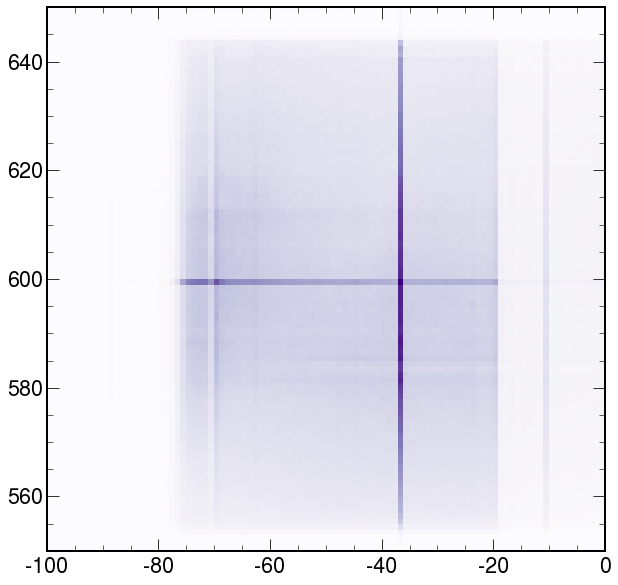

In [86]:
print("prop x", ak.flatten(prophits_x_chamber[residual_filter]))
print("prop y", ak.flatten(prophits_y_chamber[residual_filter]))

restrict_residuals = ak.flatten(prophits_x_chamber[residual_filter])<-40
restrict_residuals = restrict_residuals&(ak.flatten(prophits_x_chamber[residual_filter])>-60)
restrict_residuals = restrict_residuals&(ak.flatten(prophits_y_chamber[residual_filter])>600)
restrict_residuals = restrict_residuals&(ak.flatten(prophits_y_chamber[residual_filter])<620)
print(restrict_residuals)

_ = plt.hist2d(
    ak.flatten(prophits_x_chamber[residual_filter])[restrict_residuals],
    ak.flatten(prophits_y_chamber[residual_filter])[restrict_residuals],
    range=((-100,0),(550,650)), bins=100
)

Residual sigma: 0.22735253715474446
2500043 events
Residuals: [[-7.7e-05], [-7.17e-05], [-0.000226], ... [-0.000114], [0.000188, 0.172, 0.173]]
Coarse 18.91018754477423


Text(0, 1, 'Efficiency')

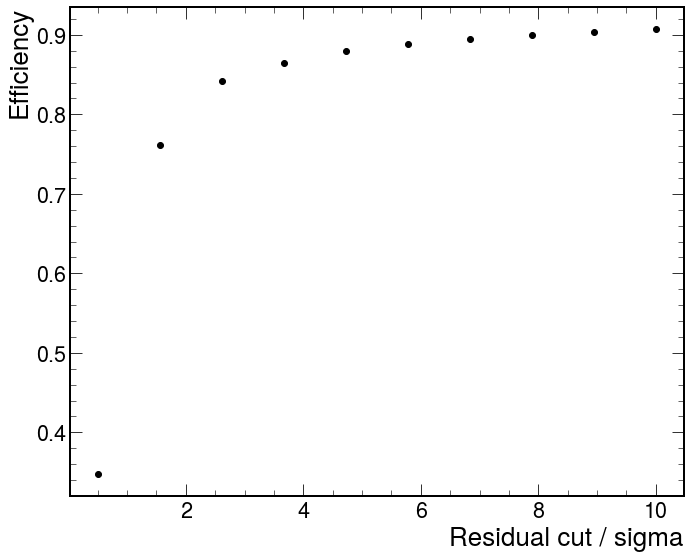

In [85]:
print("Residual sigma:", phi_resolution)
#phi_resolution = 0.233

residuals_phi_restricted = residuals_phi[restrict_residuals]

n_events = ak.num(residuals_phi_restricted, axis=0)
print(n_events, "events")
residuals_phi_restricted = ak.nan_to_num(residuals_phi_restricted, 0)
print("Residuals:", residuals_phi_restricted)
coarse_efficiency = ak.count_nonzero(ak.num(residuals_phi, axis=1)>0) / n_events
print("Coarse", coarse_efficiency)

#print(ak.count_nonzero(ak.count(residuals_phi_restricted, axis=1)>0, axis=0) / n_events)
#print(ak.count_nonzero(ak.count_nonzero(np.abs(residuals_phi_restricted)<1e10000, axis=1)>0, axis=0) / n_events)

#print(ak.count(residuals_phi_restricted, axis=1)>0)
#print(ak.count_nonzero(np.abs(residuals_phi_restricted)<1e10000, axis=1)>0)

#print(residuals_phi_restricted[~ak.count_nonzero(residuals_phi_restricted, axis=1)>0])
#print(residuals_phi_restricted[~ak.count_nonzero(np.abs(residuals_phi_restricted)<1e10000, axis=1)>0])

bad_1 = residuals_phi_restricted[~cut_1]
bad_2 = residuals_phi_restricted[~cut_2]
"""print(bad_1)
print(bad_2)
print(residuals_phi_restricted[cut_1&(~cut_2)])
print(prophits_phi_broadcast[cut_1&(~cut_2)])
print(ak.count_nonzero(prophits_phi_broadcast[cut_1&(~cut_2)], axis=1))
print(rechits_phi_broadcast[cut_1&(~cut_2)])"""

factors = np.linspace(0.5, 10, 10)
efficiencies = list()
for factor in factors:
    residual_cut = factor * phi_resolution / 1e3
    #print(residual_cut, residuals_phi_restricted)
    #print(abs(residuals_phi_restricted)<residual_cut)
    #print(ak.count_nonzero(abs(residuals_phi_restricted)<residual_cut, axis=1))
    residual_matching = ak.count_nonzero(abs(residuals_phi_restricted)<residual_cut, axis=1)>0
    #print(residual_matching)
    #print(residuals_phi_restricted[residual_matching])
    count_matching = ak.count_nonzero(residual_matching, axis=0)
    efficiency = ak.count_nonzero(ak.count_nonzero((abs(residuals_phi_restricted)<residual_cut), axis=1)>0) / n_events
    #print(factor, residual_cut, count_matching / n_events, efficiency)
    efficiencies.append(efficiency)
    #efficiency = ak.count(residuals_phi_restricted)

fig, ax = plt.subplots(figsize=(11,9))
_ = ax.plot(factors, efficiencies, "ok")
#_ = ax.plot(factors*phi_resolution, np.ones_like(factors)*coarse_efficiency, "--", color="red")
ax.set_xlabel("Residual cut / sigma")
ax.set_ylabel("Efficiency")

prop x [-9.06, 9.69, -7.63, -67.2, 5.96, -14.5, ... -36.7, -22.5, -74.6, nan, -29.2, nan]
prop y [556, 612, 592, 577, 626, 581, 558, 638, ... nan, nan, 600, 622, 586, nan, 617, nan]
[True, True, True, True, True, True, True, ... True, True, True, False, True, False]


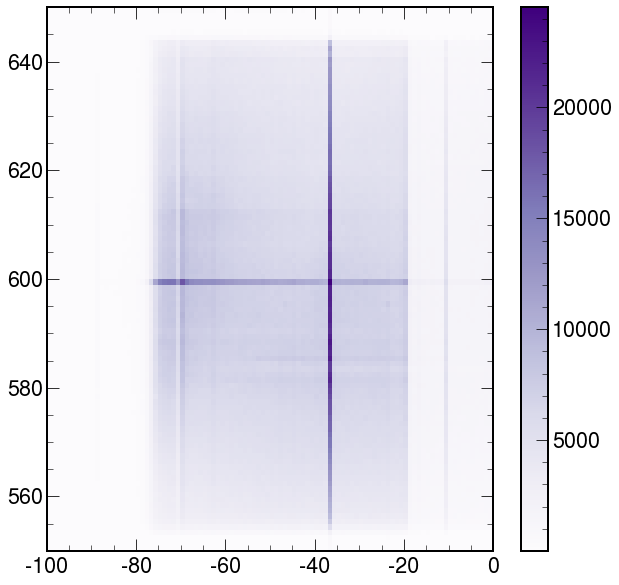

In [123]:
print("prop x", ak.flatten(prophits_x_chamber[residual_filter]))
print("prop y", ak.flatten(prophits_y_chamber[residual_filter]))

restrict_residuals = ak.flatten(prophits_x_chamber[residual_filter])<-40
restrict_residuals = restrict_residuals&(ak.flatten(prophits_x_chamber[residual_filter])>-60)
restrict_residuals = restrict_residuals&(ak.flatten(prophits_y_chamber[residual_filter])>600)
restrict_residuals = restrict_residuals&(ak.flatten(prophits_y_chamber[residual_filter])<620)
restrict_residuals = ak.flatten(prophits_x_chamber[residual_filter])<1000
print(restrict_residuals)

_ = prophit_counts, prophits_x_edges, prophits_y_edges, _ = plt.hist2d(
    ak.flatten(prophits_x_chamber[residual_filter])[restrict_residuals],
    ak.flatten(prophits_y_chamber[residual_filter])[restrict_residuals],
    range=((-100,0),(550,650)), bins=100
)
plt.colorbar()

In [154]:
print("prop x", ak.flatten(prophits_x_chamber[residual_filter]))
print("prop y", ak.flatten(prophits_y_chamber[residual_filter]))

restrict_residuals = ak.flatten(prophits_x_chamber[residual_filter])<-40
restrict_residuals = restrict_residuals&(ak.flatten(prophits_x_chamber[residual_filter])>-60)
restrict_residuals = restrict_residuals&(ak.flatten(prophits_y_chamber[residual_filter])>600)
restrict_residuals = restrict_residuals&(ak.flatten(prophits_y_chamber[residual_filter])<620)
restrict_residuals = ak.flatten(prophits_x_chamber[residual_filter])<1000
print(restrict_residuals)

eff_range = ((-100,20),(560,640))
eff_bins = 200

denom_counts, denom_x_edges, denom_y_edges, _ = plt.hist2d(
    ak.flatten(prophits_x_chamber[residual_filter]),
    ak.flatten(prophits_y_chamber[residual_filter]),
    range=eff_range, bins=eff_bins
)
plt.colorbar()

prop x [-9.06, 9.69, -7.63, -67.2, 5.96, -14.5, ... -36.7, -22.5, -74.6, nan, -29.2, nan]
prop y [556, 612, 592, 577, 626, 581, 558, 638, ... nan, nan, 600, 622, 586, nan, 617, nan]
[True, True, True, True, True, True, True, ... True, True, True, False, True, False]


In [155]:
residual_cut = 3 * phi_resolution / 1e3
print(residuals_phi)
has_matching = ak.count_nonzero(abs(residuals_phi)<residual_cut, axis=1)>0
print(has_matching)
print(ak.flatten(prophits_x_chamber[residual_filter])[has_matching])
print(ak.flatten(prophits_y_chamber[residual_filter])[has_matching])

#efficiency = ak.count_nonzero(ak.count_nonzero((abs(residuals_phi_restricted)<residual_cut), axis=1)>0) / n_events
    
num_counts, num_x_edges, num_y_edges, _ = plt.hist2d(
    ak.flatten(prophits_x_chamber[residual_filter])[has_matching],
    ak.flatten(prophits_y_chamber[residual_filter])[has_matching],
    range=eff_range, bins=eff_bins
)
plt.colorbar()

[[0.000809], [0.000128], [0.000109], [-0.000321, ... [nan], [0.000408], [nan]]
[False, True, True, True, True, True, ... False, True, True, False, True, False]
[9.69, -7.63, -67.2, 5.96, -14.5, 0.0635, ... -25.3, -30.4, -22.5, -74.6, -29.2]
[612, 592, 577, 626, 581, 558, 638, 627, ... 566, 636, 640, 640, 578, 622, 586, 617]


/home/antonellopellecchia/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


Average efficiency nan


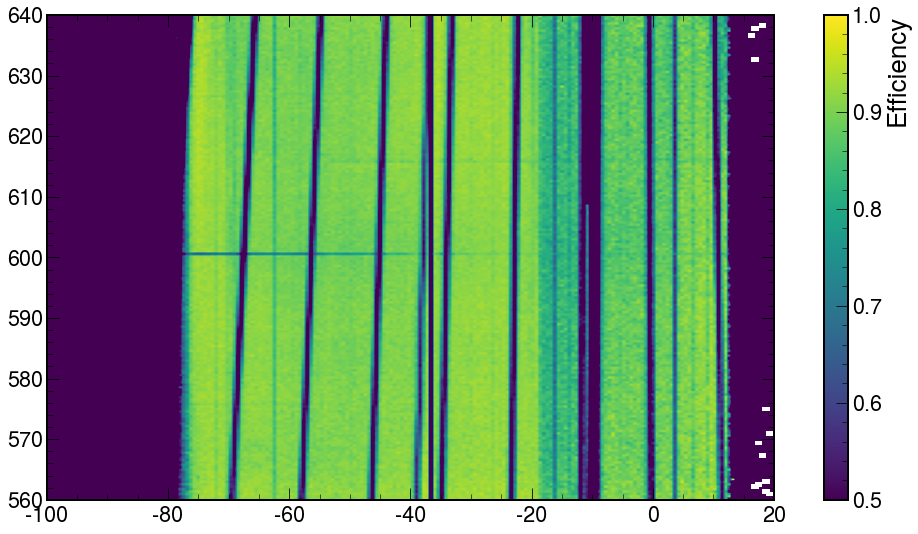

In [156]:
efficiency_map = num_counts / denom_counts
eff_fig, eff_ax = plt.subplots(figsize=(15,8))
img = eff_ax.imshow(
    efficiency_map.T,
    extent=[num_x_edges[0], num_x_edges[-1], num_y_edges[0], num_y_edges[-1]],
    cmap="viridis"#origin="lower"
)
average_efficiency = efficiency_map.flatten().mean()
print("Average efficiency", average_efficiency)
eff_fig.colorbar(img, ax=eff_ax, label="Efficiency")
img.set_clim(.5, 1.)
eff_fig.tight_layout()